In [460]:
import pandas as pd
import seaborn as sns
import warnings
sns.set(style="whitegrid", palette="pastel", color_codes=True)
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
warnings.filterwarnings('ignore')

In [408]:
region = ['Midwest', 'South', 'NewEngland']

In [409]:
# function to filter columns 
def filter_col(raw_df):
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='grade_')))]
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='age_')))]
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='rolling_')))]
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='lagged_')))]
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='cat_')))]
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='diploma_')))]
    raw_df = raw_df[raw_df.columns.drop(list(raw_df.filter(regex='college_')))]
    final = raw_df.rename(columns=lambda x: x.replace('num__', ''))
    return final

for r in region:
    # read and store as data frame
    df = pd.read_csv(f'/Users/victoriashi/Downloads/region_data/region_train/{r}.csv', parse_dates=True, index_col='date')
     #unload to global environment using the region name
    df = filter_col(df)
    df.drop(columns = ['county_fips', 'state_fips', 'county_name', 'state_name','day', 'month', 'daily_state_test'], inplace=True)
    globals()[r] = df

In [ ]:
NewEngland.head()

In [ ]:
NewEngland.columns

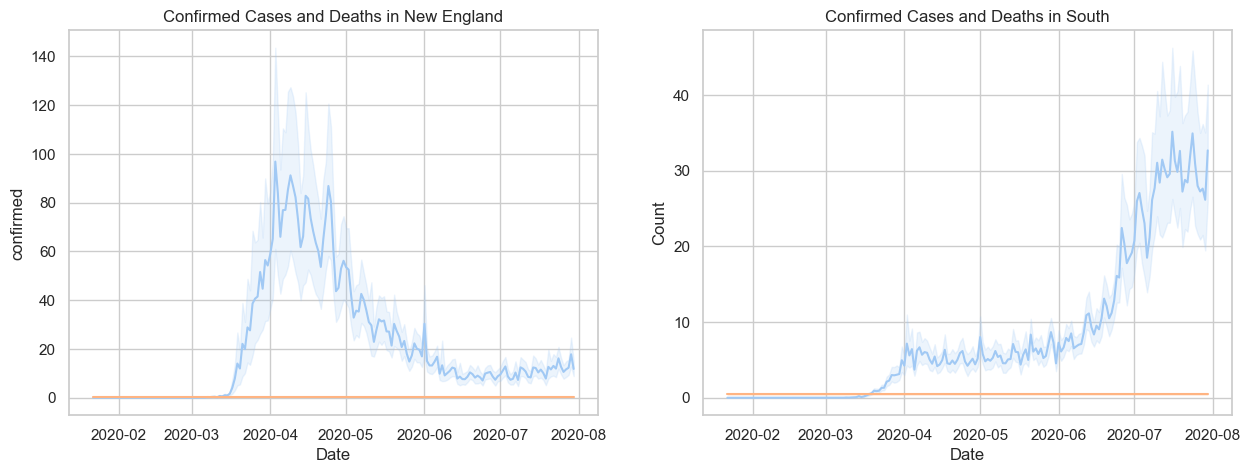

In [410]:
#side by side line plot of confirmed cases and deaths in New England and South
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x=NewEngland.index, y='confirmed', data=NewEngland, ax=axes[0])
sns.lineplot(x=NewEngland.index, y='death', data=NewEngland, ax=axes[0])
axes[0].set_title(f'Confirmed Cases and Deaths in New England')
axes[0].set_xlabel('Date')
sns.lineplot(x=South.index, y='confirmed', data=South, ax=axes[1])
sns.lineplot(x=South.index, y='death', data=South, ax=axes[1])
axes[1].set_title(f'Confirmed Cases and Deaths in South')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Date')
plt.show()

## Correlation

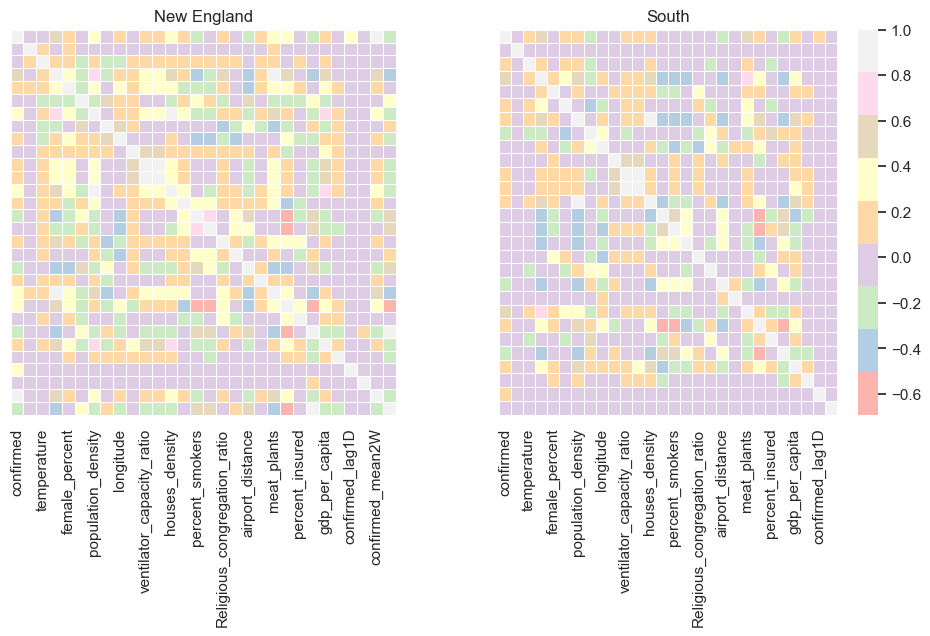

In [491]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(NewEngland.corr(), cmap='Pastel1', cbar = False, annot = False, square = True, linewidths=0.5, ax=axes[0], yticklabels=False).set_title(f'New England')
# do not show feature name in heatmap
sns.heatmap(South.corr(), cmap='Pastel1', annot = False, linewidths=0.5, ax=axes[1], yticklabels=False).set_title(f'South')
plt.show()

#### Lagged Features

lag features are the values of the previous time steps. 
The numbers of confirmed and death cases are lagged features and are respectively shifted by 1 day and 1 week to predict the confirmed and death cases for the next day.

In [430]:
# find the daily confirmed case in the previous two weeks
NewEngland[['confirmed_lag1D', 'death_lag1D']] = NewEngland[['confirmed', 'death']].diff(periods=1)
# NewEngland[['confirmed_lag1W', 'death_lag1W']] = NewEngland[['confirmed', 'death']].diff(periods=7)
ts_NE = NewEngland.drop(columns=['confirmed', 'death'], inplace=False)

South[['confirmed_lag1D', 'death_lag1D']] = South[['confirmed', 'death']].diff(periods=1)
# South[['confirmed_lag1W', 'death_lag1W']] = South[['confirmed', 'death']].diff(periods=7)
ts_S = South.drop(columns=['confirmed', 'death'], inplace=False)

#### Rolling Features

In [439]:
df = NewEngland.copy()
# Split data into training and test sets (for instance, last 30 days as test)
X_train_NE = df.iloc[:-30]
X_test = df.iloc[-30:]
y_train_NE = df.iloc[:-30].confirmed
y_test = df.iloc[-30:].confirmed
model_ar = ARIMA(ts_NE['confirmed_lag1D'], order=(0, 1, 0)).fit()
print(model_ar.summary())

                               SARIMAX Results                                
Dep. Variable:        confirmed_lag1D   No. Observations:                37627
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -215515.821
Date:                Tue, 24 Oct 2023   AIC                         431033.642
Time:                        23:20:26   BIC                         431042.178
Sample:                             0   HQIC                        431036.352
                              - 37627                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5528.3459      2.845   1943.115      0.000    5522.770    5533.922
Ljung-Box (L1) (Q):               15993.28   Jarque-Bera (JB):         250351737.89
Prob(Q):                              0.00   Pr

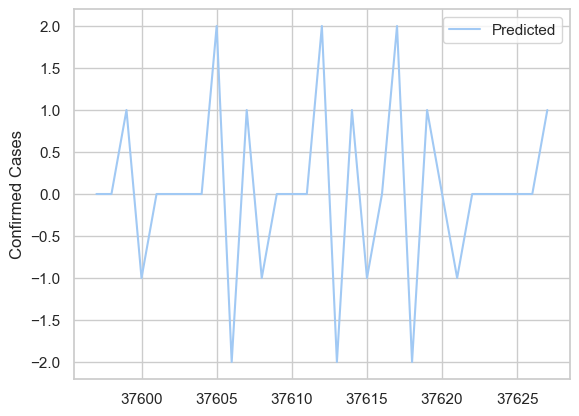

In [466]:
#predict the next 30 days
pred = model_ar.predict(start=len(y_train_NE), end=len(y_train_NE)+30)
# plot only the pred
sns.lineplot(pred, label='Predicted').set(ylabel='Confirmed Cases')
plt.xticks(None)
plt.show()

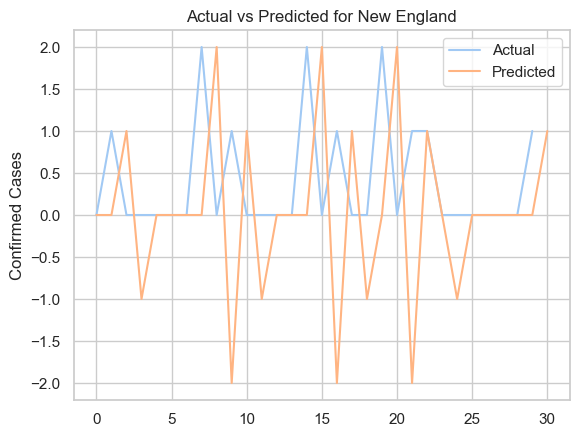

In [490]:
sns.lineplot(df.iloc[-30:].confirmed.values, label='Actual').set(ylabel='Confirmed Cases')
sns.lineplot(list(pred), label='Predicted').set(ylabel='Confirmed Cases')
plt.title('Actual vs Predicted for New England')
plt.xticks(None)
plt.show()

# SOUTH MODEL

In [539]:
df = South.copy()
# Split data into training and test sets (for instance, last 30 days as test)
X_train = ts_S.iloc[:-30]
y_train = df.iloc[:-30].confirmed
X_test = ts_S.iloc[-30:]
y_test = df.iloc[-30:].confirmed

In [493]:
df = South.copy()
# Split data into training and test sets (for instance, last 30 days as test)
X_train = ts_S.iloc[:-30]
y_train = df.iloc[:-30].confirmed

X_test = ts_S.iloc[-30:]
y_test = df.iloc[-30:].confirmed
# auto_arima
ar = auto_arima(y_train, start_p=1, start_q=2,maxiter=10,
                 max_p=3, max_q=3,max_order=3,information_criterion='bic',
                 d=1, D=1, trace=True,
                 error_action='ignore',
                 stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=1406234.191, Time=16.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1436156.830, Time=1.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1415413.532, Time=1.74 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=1406712.548, Time=8.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=1436144.854, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=1406225.424, Time=7.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : BIC=1406224.576, Time=10.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : BIC=1405912.023, Time=17.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : BIC=1405932.583, Time=22.61 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=1406284.029, Time=17.68 sec
 ARIMA(1,1,3)(0,0,0)[0]             : BIC=1405900.047, Time=5.31 sec
 ARIMA(0,1,3)(0,0,0)[0]             : BIC=1406212.600, Time=3.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=1406222.215, Time=4.52 sec
 ARIMA(2,1,3)(0,0,0)[0]             : BIC=1405920.607, 

In [541]:
ts_South = pm.ARIMA(order=(1, 1, 3), seasonal_order=(0, 0, 0, 7), with_intercept=True)

In [542]:
# fit the model
ts_South.fit(y_train)

ARIMA(order=(1, 1, 3), seasonal_order=(0, 0, 0, 7))

In [543]:
# summary
ts_South.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               158882
Model:               SARIMAX(1, 1, 3)   Log Likelihood             -702579.209
Date:                Wed, 25 Oct 2023   AIC                        1405170.417
Time:                        00:01:05   BIC                        1405230.273
Sample:                             0   HQIC                       1405188.212
                             - 158882                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.389e-05      0.054     -0.000      1.000      -0.106       0.106
ar.L1         -0.9647      0.000  -2591.973      0.000      -0.965      -0.964
ma.L1          0.5231      0.000   1140.671      0.000       0.522       0.524
ma.L2         -0.4757      0.000  -2066.941      0.000      -0.476      -0.475
ma.L3         -0.0772      0.000   -423.382      0.000      -0.078      -0.077
sigma2       405.9522      0.062   6568.728      0.000     405.831     406.073
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):       54852513717.34
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                           -15.35
Prob(H) (two-sided):                  0.00   Kurtosis:                      2881.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

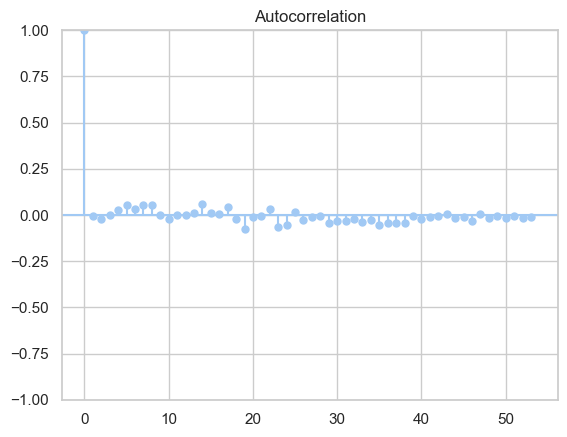

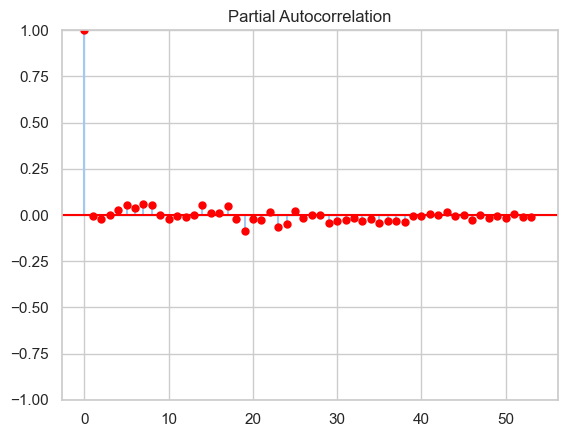

In [548]:
# plot ACF
residuals = pd.DataFrame(ts_South.resid())
plot_acf(residuals)
plt.show()

plot_pacf(residualsw)
plt.show()

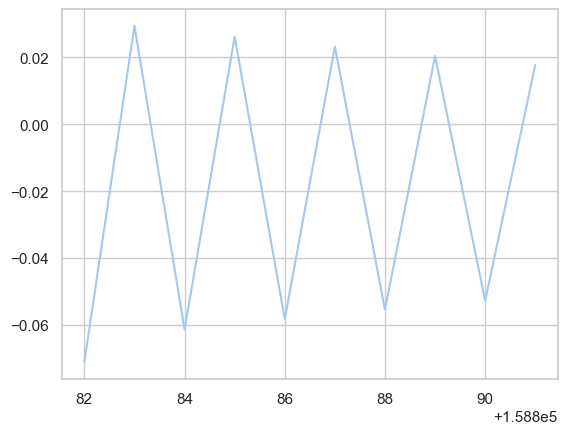

In [549]:
# plot preedictions
pred = ts_South.predict(10)
plt.plot(pred, label='Predicted')
plt.show()

# NEE


In [527]:
df = NewEngland.copy()
# Split data into training and test sets (for instance, last 30 days as test)
# X_train = ts_NE.iloc[:-30]
y_train = df.iloc[:-30].confirmed

In [524]:
df = NewEngland.copy()
# Split data into training and test sets (for instance, last 30 days as test)
X_train = ts_NE.iloc[:-30]
y_train = df.iloc[:-30].confirmed

X_test = ts_NE.iloc[-30:]
y_test = df.iloc[-30:].confirmed
# auto_arima
ar = auto_arima(y_train, start_p=1, start_q=2,maxiter=10,
                 max_p=3, max_q=3,max_order=3,information_criterion='bic',
                 d=1, D=1, trace=True,
                 error_action='ignore',
                 stepwise=True)

AttributeError: 'ARIMA' object has no attribute 'iloc'

### Best model:  ARIMA(1,1,1)(0,0,0)[0]      

In [528]:
ts_NE = pm.ARIMA(order=(1, 1, 1), seasonal_order=(0, 0, 0, 7), with_intercept=True)

In [529]:
# fit the model
ts_NE.fit(y_train)
# summary
print(ts_NE.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                37597
Model:               SARIMAX(1, 1, 1)   Log Likelihood             -190111.766
Date:                Tue, 24 Oct 2023   AIC                         380231.533
Time:                        23:59:05   BIC                         380265.672
Sample:                             0   HQIC                        380242.370
                              - 37597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.285e-05      0.093     -0.000      1.000      -0.182       0.182
ar.L1          0.0377      0.001     32.642      0.000       0.035       0.040
ma.L1         -0.6230      0.001   -661.026      0.0

In [530]:
residuals = pd.DataFrame(ts_NE.resid())

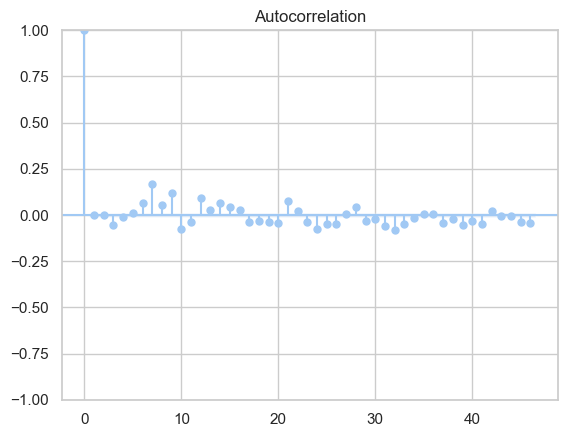

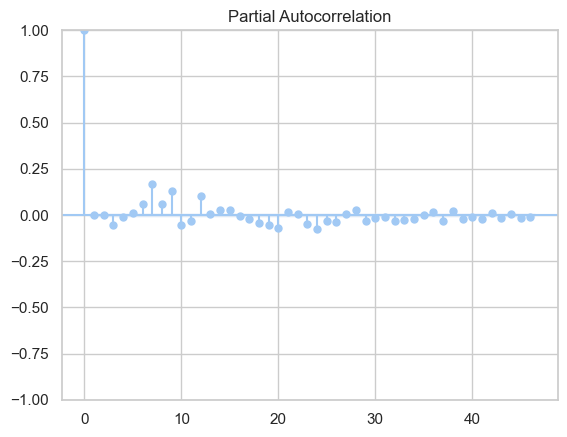

In [531]:
# plot ACF
plot_acf(residuals)
plt.show()
# plot PACF
plot_pacf(residuals)
plt.show()

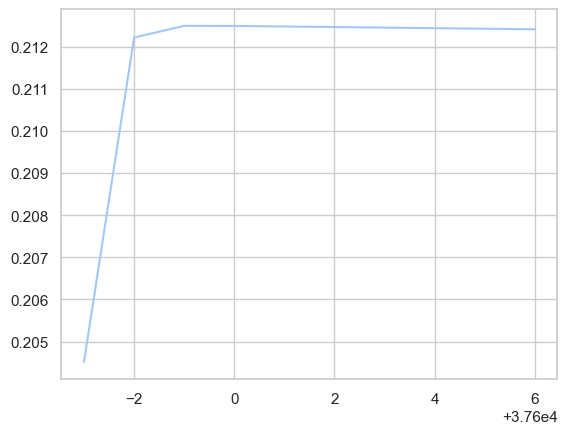

In [538]:
pred = ts_NE.predict(10)
#plot predictions
plt.plot(pred, label='Predicted')

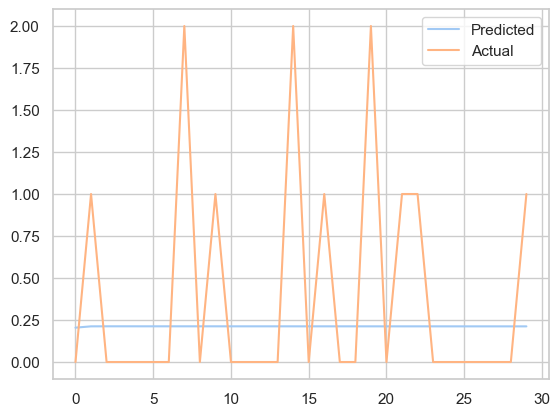

37597    0.204518
37598    0.212215
37599    0.212493
37600    0.212490
37601    0.212478
37602    0.212464
37603    0.212451
37604    0.212437
37605    0.212424
37606    0.212411
37607    0.212397
37608    0.212384
37609    0.212371
37610    0.212357
37611    0.212344
37612    0.212331
37613    0.212317
37614    0.212304
37615    0.212291
37616    0.212277
37617    0.212264
37618    0.212250
37619    0.212237
37620    0.212224
37621    0.212210
37622    0.212197
37623    0.212184
37624    0.212170
37625    0.212157
37626    0.212144
dtype: float64

In [521]:
# plot predictions

sns.lineplot(list(pred), label='Predicted')
sns.lineplot(list(y_test), label='Actual')
plt.show()

### END

In [505]:
# plot the residual
residuals = pd.DataFrame(model_ar.resid)
plot_acf(residuals)
plt.show()

ValueError: DataFrame constructor not properly called!

In [ ]:
# fit the best model ARIMA(1,1,0)(2,1,0)
model2 = ARIMA(y_train_NE, order=(0, 1, 0)).fit()
# plot the residual
residuals = pd.DataFrame(model_ar.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
ar2 = auto_arima(df['confirmed_lag1D'], start_p=1, start_q=2,
                 max_p=3, max_q=3,max_order=3,information_criterion='bic',
                 d=1, D=1, trace=True,
                 error_action='ignore',
                 stepwise=True)
# fit the Best model: ARIMA(3,1,3)(0,0,0) [0]
best = ARIMA(df['covid_19_confirmed_cases'], order=(3,1,3)).fit()
print(best.summary())
# plot the residual
residuals = pd.DataFrame(best.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
# compare the predicted with the actual confirmed for the next 10 days
best.predict(start=1, end=100)
# find the first non-zero value in the prediction
pred = best.predict(start=1, end=100)
# plot
sns.lineplot(pred, label='Predicted')
# plot
plt.plot(df['covid_19_confirmed_cases'].iloc[0:100].nonzero()[0], best.predict(start=1, end=100), color='red', label='Predicted')

### Check for Stationarity using ADF test

In [ ]:
# Check for Stationarity using ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'{key}: {value}')

In [ ]:
ts = NewEngland['confirmed']
# Plot ACF
plt.figure(figsize=(9,5))
plot_acf(ts, lags=40)
plt.title('Autocorrelation Function')
# Plot PACF
plot_pacf(ts, lags=40)
plt.title('Partial Autocorrelation Function')
plt.show()

#### New England

In [ ]:
# Split data into training and test sets (for instance, last 30 days as test)
X_train_NE = ts_NE.iloc[:-30]
y_train_NE = NewEngland.iloc[:-30].confirmed

X_test_NE = ts_NE.iloc[:-30]
y_test_NE = NewEngland.iloc[:-30].confirmed
print(X_train_NE.shape, y_train_NE.shape, X_test_NE.shape, y_test_NE.shape)
len(X_test_NE)
len(y_test_NE)

In [ ]:
ts_model_NE = auto_arima(y_train_NE, exogenous=X_train_NE, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True, maxiter=10, max_p=3, max_q=3)

# Fit the model
ts_model_NE.fit(y_train_NE, exogenous=X_train_NE)

ARIMA
non-seasonal component: (2,1,2)

AR(2): Autoregressive order of 2.
I(1): Integrated of order 1
MA(2): Moving Average order of 2.

seasonal components: (2,0,2)[7]

SAR(2): Seasonal Autoregressive order of 2.
SMA(2): Seasonal Moving Average order of 2.
Periodicity of 7: The model considers a season to be 7 periods long, which suggests a weekly seasonality.

In [ ]:
import pmdarima as pm

In [ ]:
ts_NE = pm.ARIMA(order=(2, 1, 2), seasonal_order=(2, 0, 2, 7), with_intercept=True)

In [ ]:
ts_NE.fit(y_train_NE, exogenous=X_train_NE)

In [ ]:
print(ts_NE.summary())

In [ ]:
forecast, conf_int = ts_NE.predict(X_test_NE, return_conf_int=True, n_periods=30)

In [ ]:
len(forecast)

In [ ]:
# plot the forcast
plt.figure(figsize=(10, 5))
plt.plot(y_train_NE, label='Training')
plt.plot(y_train_NE.index[-30:], y_test_NE, label='Test')
plt.plot(y_train_NE.index[-30:], forecast, label='Forecast')
plt.fill_between(y_train_NE.index[-30:], conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast')

#### South

In [ ]:
X_train_S = ts_S.iloc[:-30]
y_train_S = South.iloc[:-30].confirmed

X_test_S = ts_S.iloc[-30:]
y_test_S = South.iloc[-30:].confirmed

ts_model_S = auto_arima(y_train_S, exogenous=X_train_S, seasonal=True, trace=True, error_action='ignore',
                         suppress_warnings=True, max_p=3, max_q=3)

# Fit the model
ts_model_S.fit(y_train_S, exogenous=X_train_S)


In [ ]:
ts_model_S.summary()


In [ ]:
# Forecast
forecast, conf_int = ts_model_S.predict(n_periods=30, exogenous=X_test_S, return_conf_int=True)


In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_train_S, label='Training')
plt.plot(y_train_S.index[-30:], y_test_S, label='Test')
plt.plot(y_train_S.index[-30:], forecast, label='Forecast')
plt.fill_between(y_train_S.index[-30:], conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


### ARIMA